# File Setup

In [12]:
!cp "/content/drive/MyDrive/Colab Notebooks/SpamData.zip" ./
!unzip SpamData > unzip.log

cp: /content/drive/MyDrive/Colab Notebooks/SpamData.zip: No such file or directory
unzip:  cannot find or open SpamData, SpamData.zip or SpamData.ZIP.


# Imports

In [153]:
from os import walk
from os.path import join
import pandas as pd

import matplotlib.pyplot as plt

import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from bs4 import BeautifulSoup
from wordcloud import WordCloud
from PIL import Image
import numpy as np

from sklearn.model_selection import train_test_split

%matplotlib inline

## Constants

In [173]:
EXAMPLE_FILE = "SpamData/01_Processing/practice_email.txt"

SPAM_1_PATH = "SpamData/01_Processing/spam_assassin_corpus/spam_1"
SPAM_2_PATH = "SpamData/01_Processing/spam_assassin_corpus/spam_2"
EASY_NONSPAM_1_PATH = "SpamData/01_Processing/spam_assassin_corpus/easy_ham_1"
EASY_NONSPAM_2_PATH = "SpamData/01_Processing/spam_assassin_corpus/easy_ham_2"

SPAM_CAT = 1
HAM_CAT = 0
VOCAB_SIZE = 2500

WORD_ID_FILE = "SpamData/01_Processing/word-by-id.csv"
DATA_JSON_FILE = "SpamData/01_Processing/email-text-data.json"

TRAINING_DATA_FILE = "./SpamData/02_Training/train-data.txt"
TEST_DATA_FILE = "./SpamData/02_Training/test-data.txt"


WHALE_FILE = "SpamData/01_Processing/wordcloud_resources/whale-icon.png"

In [15]:
print(SPAM_1_PATH)

SpamData/01_Processing/spam_assassin_corpus/spam_1


## Reading Files

In [16]:
stream = open(EXAMPLE_FILE, encoding='latin-1')
message = stream.read()
stream.close()

print(message)

From exmh-workers-admin@redhat.com  Thu Aug 22 12:36:23 2002
Return-Path: <exmh-workers-admin@spamassassin.taint.org>
Delivered-To: zzzz@localhost.netnoteinc.com
Received: from localhost (localhost [127.0.0.1])
	by phobos.labs.netnoteinc.com (Postfix) with ESMTP id D03E543C36
	for <zzzz@localhost>; Thu, 22 Aug 2002 07:36:16 -0400 (EDT)
Received: from phobos [127.0.0.1]
	by localhost with IMAP (fetchmail-5.9.0)
	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 12:36:16 +0100 (IST)
Received: from listman.spamassassin.taint.org (listman.spamassassin.taint.org [66.187.233.211]) by
    dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id g7MBYrZ04811 for
    <zzzz-exmh@spamassassin.taint.org>; Thu, 22 Aug 2002 12:34:53 +0100
Received: from listman.spamassassin.taint.org (localhost.localdomain [127.0.0.1]) by
    listman.redhat.com (Postfix) with ESMTP id 8386540858; Thu, 22 Aug 2002
    07:35:02 -0400 (EDT)
Delivered-To: exmh-workers@listman.spamassassin.taint.org
Received: from int-mx1.corp

In [17]:
import sys
sys.getfilesystemencoding()

'utf-8'

In [18]:
stream = open(EXAMPLE_FILE, encoding='latin-1')

is_body = False
lines = []

for line in stream:
    if is_body:
        lines.append(line)
    elif line == "\n":
        is_body = True

stream.close()

email_body = "\n".join(lines)
print(email_body)

print(lines)



Dear Mr Still



Good tidings to you and all your staff for the festive season ahead (Christmas).

Now to the crux of the matter-in-hand: I am a fully qualified Santa Claus and am wondering whether you might consider me to run my own "Santa's Grotto" in your store.

But WAIT! You're probably thinking: "What makes him so special?"

Well, first of all, I have made several changes to the characterisation of Father Christmas. Rather than greeting the children with shouts of "Ho, ho, ho!" I prefer to whisper the phrase "Dependence is not unfathomable in this cruel world we live in". In addition, my gifts are ALL hand-made, ranging from felt hoops to vanilla-pod holders.

You will note also, from the enclosed sketch, that I have radically redesigned Santa's outfit and have renamed my character "Lord Buckles". Would you be interested in employing me? I promise NEVER to let you down.

I look forward to hearing from you.



Best wishes

Robin Cooper

[Excerpt from the book: The Timewaster Let

# Generator Functions

In [19]:
def generate_squares(N):
    for my_number in range(N):
        yield my_number ** 2

In [20]:
for i in generate_squares(5):
    print(i, end=' ->')

0 ->1 ->4 ->9 ->16 ->

## Email body extraction

In [21]:
def email_body_generator(path):
    
    for root, dirnames, filenames in walk(path):

        for file_name in filenames:

            filepath = join(root, file_name)

            stream = open(filepath, encoding='latin-1')

            is_body = False
            lines = []

            for line in stream:
                if is_body:
                    lines.append(line)
                elif line == "\n":
                    is_body = True

            stream.close()

            email_body = "\n".join(lines)
            
            yield file_name, email_body

In [22]:
def df_from_directory(path, classification):
    rows = []
    row_names = []
    for file_name, email_body in email_body_generator(path):
        rows.append({'MESSAGE': email_body, 'CATEGORY': classification})
        row_names.append(file_name)
    return pd.DataFrame(rows, index=row_names)

In [23]:
spam_emails = df_from_directory(SPAM_1_PATH, SPAM_CAT)
spam_emails = spam_emails.append(df_from_directory(SPAM_2_PATH, SPAM_CAT))

spam_emails.head()

,MESSAGE,CATEGORY
00249.5f45607c1bffe89f60ba1ec9f878039a,"Dear Homeowner,\n\n \n\nInterest Rates are at ...",1
00373.ebe8670ac56b04125c25100a36ab0510,ATTENTION: This is a MUST for ALL Computer Use...,1
00214.1367039e50dc6b7adb0f2aa8aba83216,This is a multi-part message in MIME format.\n...,1
00210.050ffd105bd4e006771ee63cabc59978,IMPORTANT INFORMATION:\n\n\n\nThe new domain n...,1
00033.9babb58d9298daa2963d4f514193d7d6,This is the bottom line. If you can GIVE AWAY...,1


In [24]:
spam_emails.shape

(1898, 2)

In [25]:
ham_emails = df_from_directory(EASY_NONSPAM_1_PATH, HAM_CAT)
ham_emails = ham_emails.append(df_from_directory(EASY_NONSPAM_2_PATH, HAM_CAT))

ham_emails.head()

,MESSAGE,CATEGORY
00769.25bf9a767b5db0ed93f03c1637281663,"\n\nIn a message dated 9/24/2002 11:24:58 AM, ...",0
01074.8590d61ac0aeeadb58dc2f2ba776c406,"Hiya, I always seem to get errors when I do an...",0
02479.14365bcad3a60fcf24c5c1813f6291fb,\n\nI don't know how one can expect better and...,0
01417.ce7b07a2114218dbac682b599785820d,Tim Peters wrote:\n\n> I've run no experiments...,0
00357.d559b71616f64ba1d1c1e61a03644fd4,"At 10:34 AM -0700 on 8/28/02, Jim Whitehead wr...",0


In [26]:
ham_emails.shape

(3901, 2)

In [27]:
data = pd.concat([spam_emails, ham_emails])
print("Shape of entire dataframe is ", data.shape)
data.head()

Shape of entire dataframe is  (5799, 2)


,MESSAGE,CATEGORY
00249.5f45607c1bffe89f60ba1ec9f878039a,"Dear Homeowner,\n\n \n\nInterest Rates are at ...",1
00373.ebe8670ac56b04125c25100a36ab0510,ATTENTION: This is a MUST for ALL Computer Use...,1
00214.1367039e50dc6b7adb0f2aa8aba83216,This is a multi-part message in MIME format.\n...,1
00210.050ffd105bd4e006771ee63cabc59978,IMPORTANT INFORMATION:\n\n\n\nThe new domain n...,1
00033.9babb58d9298daa2963d4f514193d7d6,This is the bottom line. If you can GIVE AWAY...,1


# Data Cleaning: Checking for Missing Values

In [28]:
# check if any message bodies are null
data['MESSAGE'].isnull().values.any()

False

In [29]:
# check if there are empty emails (string length zero)
(data.MESSAGE.str.len() == 0).any()

True

In [30]:
(data.MESSAGE.str.len() == 0).sum()

3

### Locate empty emails

In [31]:
data[data.MESSAGE.str.len() == 0].index

Index(['cmds', 'cmds', 'cmds'], dtype='object')

In [32]:
data.index.get_loc('cmds')

array([False, False, False, ..., False, False, False])

# Remove System File Entries from Dataframe

In [33]:
data.drop(['cmds'], inplace=True)

In [34]:
data.shape

(5796, 2)

# Add Document IDs to Track Emails in Dataset

In [35]:
document_ids = range(0, len(data.index))
data['DOC_ID'] = document_ids

In [36]:
data['FILE_NAME'] = data.index
data.set_index('DOC_ID', inplace=True)
data.head()

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
0,"Dear Homeowner,\n\n \n\nInterest Rates are at ...",1,00249.5f45607c1bffe89f60ba1ec9f878039a
1,ATTENTION: This is a MUST for ALL Computer Use...,1,00373.ebe8670ac56b04125c25100a36ab0510
2,This is a multi-part message in MIME format.\n...,1,00214.1367039e50dc6b7adb0f2aa8aba83216
3,IMPORTANT INFORMATION:\n\n\n\nThe new domain n...,1,00210.050ffd105bd4e006771ee63cabc59978
4,This is the bottom line. If you can GIVE AWAY...,1,00033.9babb58d9298daa2963d4f514193d7d6


In [37]:
data.tail()

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
5791,"I'm one of the 30,000 but it's not working ver...",0,00609.dd49926ce94a1ea328cce9b62825bc97
5792,Damien Morton quoted:\n\n>W3C approves HTML 4 ...,0,00957.e0b56b117f3ec5f85e432a9d2a47801f
5793,"On Mon, 2002-07-22 at 06:50, che wrote:\n\n\n\...",0,01127.841233b48eceb74a825417d8d918abf8
5794,"Once upon a time, Manfred wrote :\n\n\n\n> I w...",0,01178.5c977dff972cd6eef64d4173b90307f0
5795,"If you run Pick, and then use the ""New FTOC"" b...",0,00747.352d424267d36975a7b40b85ffd0885e


# Save to File using Pandas

In [38]:
data.to_json(DATA_JSON_FILE)

# Number of Spam Messages Visualised (Pie Charts)

In [39]:
data.CATEGORY.value_counts()

0    3900
1    1896
Name: CATEGORY, dtype: int64

In [40]:
amount_of_spam = data.CATEGORY.value_counts()[1]
amount_of_ham = data.CATEGORY.value_counts()[0]

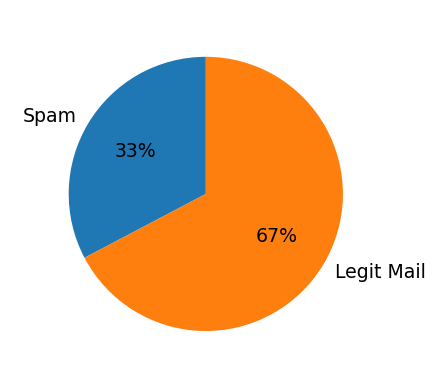

In [41]:
category_names = ['Spam', "Legit Mail"]
sizes = [amount_of_spam, amount_of_ham]

plt.figure(figsize=(2,2), dpi=227)
plt.pie(sizes, labels=category_names, textprops={'fontsize': 6}, startangle=90,
        autopct='%1.0f%%')
plt.show()

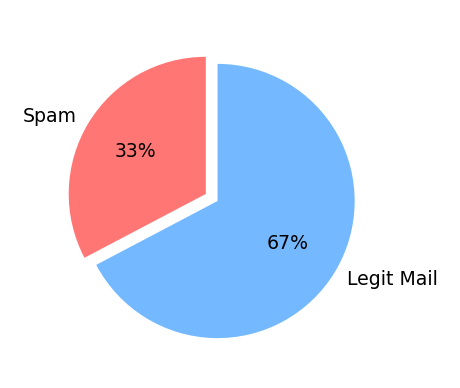

In [42]:
custom_colors=['#ff7675', '#74b9ff']

plt.figure(figsize=(2,2), dpi=227)
plt.pie(sizes, labels=category_names, textprops={'fontsize': 6}, startangle=90,
        autopct='%1.0f%%', colors=custom_colors, explode=[0, 0.1])
plt.show()

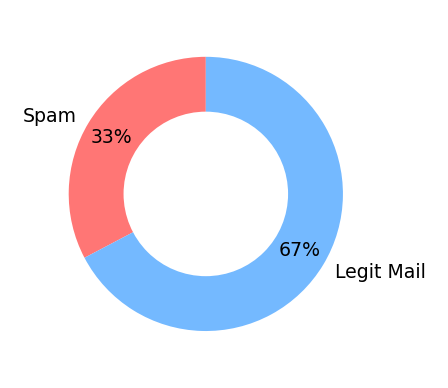

In [43]:
plt.figure(figsize=(2,2), dpi=227)
plt.pie(sizes, labels=category_names, textprops={'fontsize': 6}, startangle=90,
        autopct='%1.0f%%', colors=custom_colors, pctdistance=0.8)

# draw circle
center_circle = plt.Circle((0,0), radius=0.6, fc='white')
plt.gca().add_artist(center_circle)
plt.show()

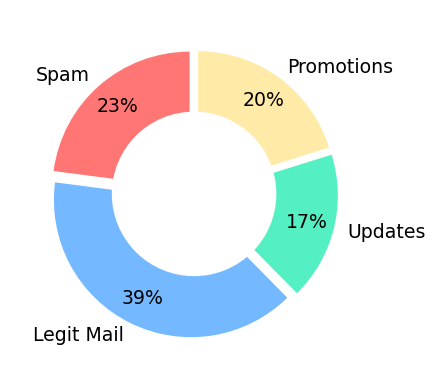

In [44]:
category_names = ['Spam', "Legit Mail", 'Updates', 'Promotions']
sizes = [25, 43, 19, 22]
custom_colors=['#ff7675', '#74b9ff', '#55efc4', '#ffeaa7']
offset = [0.05, 0.05, 0.05, 0.05]

plt.figure(figsize=(2,2), dpi=227)
plt.pie(sizes, labels=category_names, textprops={'fontsize': 6}, startangle=90,
        autopct='%1.0f%%', colors=custom_colors, pctdistance=0.8, explode=offset)

# draw circle
center_circle = plt.Circle((0,0), radius=0.6, fc='white')
plt.gca().add_artist(center_circle)
plt.show()

# Natural Language Processing

### Text Pre-Processing

In [45]:
# convert to lower case
msg = "All work and no play makes Jack a dull boy."
msg.lower()

'all work and no play makes jack a dull boy.'

### Download the NLTK Resources (Tokenizer & Stopwords)

In [46]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/wburn/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [47]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/wburn/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Tokenizing

In [48]:
msg = "All work and no play makes Jack a dull boy."
word_tokenize(msg.lower())

['all', 'work', 'and', 'no', 'play', 'makes', 'jack', 'a', 'dull', 'boy', '.']

## Removing Stop Words

In [49]:
stop_words = set(stopwords.words('english'))
type(stop_words)

set

In [50]:
if 'this' in stop_words: print('Found it!')

Found it!


In [51]:
if 'hello' not in stop_words: print('Nope, not in here!')

Nope, not in here!


In [52]:
msg = "All work and no play makes Jack a dull boy. To be or not to be."
words = word_tokenize(msg.lower())

filtered_words = [word for word in words if word not in stop_words]
filtered_words


['work', 'play', 'makes', 'jack', 'dull', 'boy', '.', '.']

## Word Stems and Stemming

In [53]:
msg = "All work and no play makes Jack a dull boy. To be or not to be. \
        Nobody expects the Spanish Inquisition!"
words = word_tokenize(msg.lower())

stemmer = PorterStemmer()

filtered_words = []
for word in words:
    if word not in stop_words:
        stemmed_word = stemmer.stem(word)
        filtered_words.append(stemmed_word)

print(filtered_words)

['work', 'play', 'make', 'jack', 'dull', 'boy', '.', '.', 'nobodi', 'expect', 'spanish', 'inquisit', '!']


### Removing Punctuation

In [54]:
msg = "All work and no play makes Jack a dull boy. To be or not to be. \
        Nobody expects the Spanish Inquisition!"
words = word_tokenize(msg.lower())

stemmer = PorterStemmer()

filtered_words = []
for word in words:
    if word not in stop_words and word.isalpha():
        stemmed_word = stemmer.stem(word)
        filtered_words.append(stemmed_word)

print(filtered_words)

['work', 'play', 'make', 'jack', 'dull', 'boy', 'nobodi', 'expect', 'spanish', 'inquisit']


# Removing HTML tags from Emails

In [55]:
soup = BeautifulSoup(data.at[1, 'MESSAGE'], 'html.parser')
print(soup.prettify())

ATTENTION: This is a MUST for ALL Computer Users!!!



*NEW-Special Package Deal!*



Norton SystemWorks 2002 Software Suite -Professional Edition-



Includes Six - Yes 6! - Feature-Packed Utilities

ALL For 1 Special LOW Price!



This Software Will:

- Protect your computer from unwanted and hazardous viruses

- Help secure your private &amp; valuable information

- Allow you to transfer files and send e-mails safely

- Backup your ALL your data quick and easily

- Improve your PC's performance w/superior integral diagnostics!



6 Feature-Packed Utilities...1 Great Price!

A $300+ Combined Retail Value!



YOURS for Only $29.99!
<includes free="" shipping!="">
 Don't fall prey to destructive viruses or hackers!

Protect  your computer and your valuable information!





So don't delay...get your copy TODAY!





http://euro.specialdiscounts4u.com/

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

This email has been screened and filtered by our in house

In [56]:
soup.get_text()

'ATTENTION: This is a MUST for ALL Computer Users!!!\n\n\n\n*NEW-Special Package Deal!*\n\n\n\nNorton SystemWorks 2002 Software Suite -Professional Edition-\n\n\n\nIncludes Six - Yes 6! - Feature-Packed Utilities\n\nALL For 1 Special LOW Price!\n\n\n\nThis Software Will:\n\n- Protect your computer from unwanted and hazardous viruses\n\n- Help secure your private & valuable information\n\n- Allow you to transfer files and send e-mails safely\n\n- Backup your ALL your data quick and easily\n\n- Improve your PC\'s performance w/superior integral diagnostics!\n\n\n\n6 Feature-Packed Utilities...1 Great Price!\n\nA $300+ Combined Retail Value!\n\n\n\nYOURS for Only $29.99!  \n\n\n\nDon\'t fall prey to destructive viruses or hackers!\n\nProtect  your computer and your valuable information!\n\n\n\n\n\nSo don\'t delay...get your copy TODAY!\n\n\n\n\n\nhttp://euro.specialdiscounts4u.com/\n\n++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++\n\nThis email has been scree

## Functions for Email Processing

In [57]:
def clean_message(message, stemmer=PorterStemmer(), 
                  stop_words=set(stopwords.words('english'))):
    
    words = word_tokenize(message.lower())
    filtered_words = []

    for word in words:
        if word not in stop_words and word.isalpha:
            filtered_words.append(stemmer.stem(word))

    return filtered_words

In [58]:
def clean_message_no_html(message, stemmer=PorterStemmer(), 
                  stop_words=set(stopwords.words('english'))):
    soup = BeautifulSoup(message, 'html.parser')
    words = word_tokenize(soup.get_text().lower())
    filtered_words = []

    for word in words:
        if word not in stop_words and word.isalpha():
            filtered_words.append(stemmer.stem(word))

    return filtered_words

In [59]:
clean_message_no_html(data.at[2, 'MESSAGE'])

['messag',
 'mime',
 'format',
 'dare',
 'tri',
 'find',
 'better',
 'annuiti',
 'guarante',
 'year',
 'surrend',
 'agent',
 'commiss',
 'age',
 'call',
 'today',
 'inform',
 'ext',
 'pleas',
 'fill',
 'form',
 'inform',
 'name',
 'phone',
 'citi',
 'state',
 'pmg',
 'financi',
 'servic',
 'deposit',
 'interest',
 'deposit',
 'total',
 'want',
 'anyon',
 'receiv',
 'mail',
 'wish',
 'receiv',
 'profession',
 'commun',
 'sent',
 'insur',
 'profession',
 'remov',
 'mail',
 'list',
 'repli',
 'messag',
 'instead',
 'go',
 'http',
 'legal',
 'notic',
 'dare',
 'find',
 'better',
 'annuiti',
 'call',
 'today',
 'inform',
 'pleas',
 'fill',
 'form',
 'inform',
 'name',
 'phone',
 'citi',
 'state',
 'deposit',
 'interest',
 'deposit',
 'total',
 'want',
 'anyon',
 'receiv',
 'mail',
 'wish',
 'receiv',
 'profession',
 'sent',
 'insur',
 'profession',
 'remov',
 'list',
 'repli',
 'messag',
 'instead',
 'go',
 'http',
 'legal',
 'notic']

# Apply Cleaning and Tokenisation to all messages

### Slicing Dataframes and Series & Creating Subsets

In [60]:
data.iat[2,2]

'00214.1367039e50dc6b7adb0f2aa8aba83216'

In [61]:
data.iloc[5:11]

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
5,------=_NextPart_000_00B8_51E06B6A.C8586B31\n\...,1,00187.efd97ab2034b3384606e21db00014ecb
6,"<STYLE type=""text/css"">\n\n<!--\n\nP{\n\n fon...",1,00500.85b72f09f6778a085dc8b6821965a76f
7,<HR>\n\n<html>\n\n<head>\n\n <title>Secured I...,1,00493.1c5f59825f7a246187c137614fb1ea82
8,"<table width=""600"" border=""20"" align=""center"" ...",1,00012.381e4f512915109ba1e0853a7a8407b2
9,"<html>\n\n\n\n<head>\n\n<meta http-equiv=""Cont...",1,00487.139a2f4e8edbbdd64441536308169d74
10,"Dear Consumers, Increase your Business Sales! ...",1,00159.b16f070a576c2eb1533aa9e2cf8e6b77


In [62]:
first_emails = data.MESSAGE.iloc[0:3]

nested_list = first_emails.apply(clean_message_no_html)

In [63]:
# flat_list = []
# for sublist in nested_list:
#     for item in sublist:
#         flat_list.append(item)

flat_list = [item for sublist in nested_list for item in sublist]

len(flat_list)

222

In [64]:
%%time
# use apply() on all the messages in the dataframe
nested_list = data.MESSAGE.apply(clean_message_no_html)

/Users/wburn/notebooks/machine-learning-course/venv/lib/python3.9/site-packages/bs4/__init__.py:417: MarkupResemblesLocatorWarning: "http://www.post-gazette.com/columnists/20020905brian5
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(


CPU times: user 44.2 s, sys: 528 ms, total: 44.7 s
Wall time: 45.3 s


In [65]:
nested_list.head()

DOC_ID
0    [dear, homeown, interest, rate, lowest, point,...
1    [attent, must, comput, user, packag, deal, nor...
2    [messag, mime, format, dare, tri, find, better...
3    [import, inform, new, domain, name, final, ava...
4    [bottom, line, give, away, cd, free, peopl, li...
Name: MESSAGE, dtype: object

In [66]:
nested_list.tail()

DOC_ID
5791    [one, work, well, week, te, updat, server, syn...
5792    [damien, morton, quot, approv, html, abl, say,...
5793    [mon, che, wrote, that, correct, line, ad, rep...
5794    [upon, time, manfr, wrote, would, like, instal...
5795    [run, pick, use, new, ftoc, button, show, mess...
Name: MESSAGE, dtype: object

### Using Logic to Slice DataFrames

In [67]:
data[data.CATEGORY == 1].shape

(1896, 3)

In [68]:
data[data.CATEGORY == 1].tail

<bound method NDFrame.tail of                                                   MESSAGE  CATEGORY  \
DOC_ID                                                                
0       Dear Homeowner,\n\n \n\nInterest Rates are at ...         1   
1       ATTENTION: This is a MUST for ALL Computer Use...         1   
2       This is a multi-part message in MIME format.\n...         1   
3       IMPORTANT INFORMATION:\n\n\n\nThe new domain n...         1   
4       This is the bottom line.  If you can GIVE AWAY...         1   
...                                                   ...       ...   
1891    <!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.0 Tr...         1   
1892    <html>\n\n<HEAD> \n\n<TITLE>creditfix</TITLE> ...         1   
1893    Hello:\n\n\n\nAre you satisfied with your ISP?...         1   
1894    <html><HEAD><TITLE>creditfix</TITLE> \n\n</HEA...         1   
1895    <HTML><HEAD></HEAD><BODY><b><FONT SIZE=3D4>In ...         1   

                                     FILE_NAME

In [69]:
doc_ids_spam = data[data.CATEGORY == 1].index
doc_ids_ham = data[data.CATEGORY == 0].index

### Subsetting A Series with an Index

In [70]:
nested_list_ham = nested_list.loc[doc_ids_ham]

In [71]:
nested_list_ham.shape

(3900,)

In [72]:
nested_list_ham.tail()

DOC_ID
5791    [one, work, well, week, te, updat, server, syn...
5792    [damien, morton, quot, approv, html, abl, say,...
5793    [mon, che, wrote, that, correct, line, ad, rep...
5794    [upon, time, manfr, wrote, would, like, instal...
5795    [run, pick, use, new, ftoc, button, show, mess...
Name: MESSAGE, dtype: object

In [73]:
nested_list_spam = nested_list.loc[doc_ids_spam]

In [74]:
flat_list_ham = [word for sublist in nested_list_ham for word in sublist]
normal_words = pd.Series(flat_list_ham).value_counts()

normal_words.shape[0] # total number of unique words in the non-spam messages

20815

In [75]:
normal_words[:10]

http      7563
use       3633
list      2880
one       2373
get       2286
mail      2255
would     2003
like      1931
messag    1849
work      1800
dtype: int64

In [76]:
flat_list_spam = [word for sublist in nested_list_spam for word in sublist]
spammy_words = pd.Series(flat_list_spam).value_counts()

spammy_words.shape[0] # total number of unique words in the non-spam messages

13242

In [77]:
spammy_words[:10]

http      3097
email     3090
free      2585
click     2058
receiv    1989
list      1971
get       1914
pleas     1852
busi      1792
order     1746
dtype: int64

# Creating a Word Cloud

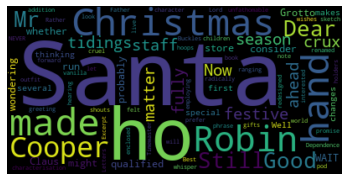

In [78]:
word_cloud = WordCloud().generate(email_body)
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [97]:
nltk.download('gutenberg')
nltk.download('shakespeare')

[nltk_data] Downloading package gutenberg to /Users/wburn/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package shakespeare to
[nltk_data]     /Users/wburn/nltk_data...
[nltk_data]   Package shakespeare is already up-to-date!


True

In [80]:
example_corpus = nltk.corpus.gutenberg.words('melville-moby_dick.txt')
len(example_corpus)

260819

In [81]:
type(example_corpus)

nltk.corpus.reader.util.StreamBackedCorpusView

In [82]:
word_list = [''.join(word) for word in example_corpus]

In [83]:
novel_as_string = ' '.join(word_list)

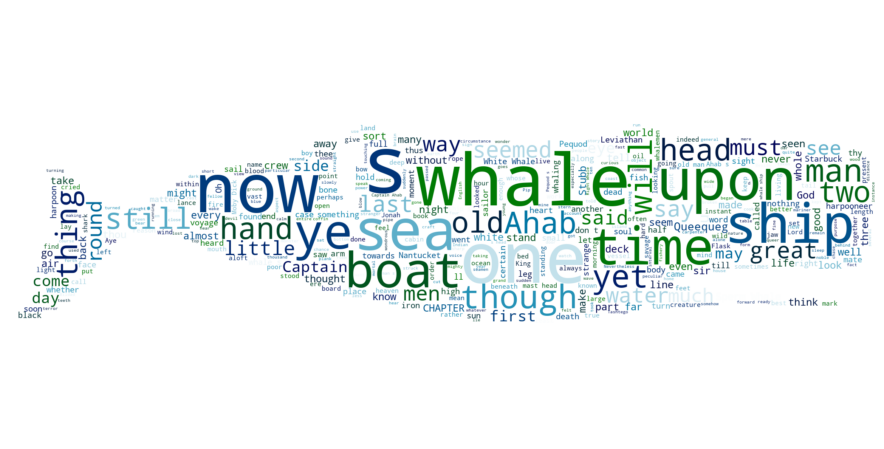

In [95]:
icon = Image.open(WHALE_FILE)
image_mask = Image.new(mode='RGB', size=icon.size, color=(255, 255, 255))
image_mask.paste(icon, box=icon)

rgb_array = np.array(image_mask)

word_cloud = WordCloud(mask=rgb_array, background_color='white',
                       max_words=400, colormap='ocean')
word_cloud.generate(novel_as_string)

plt.figure(figsize=[16, 8])
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [93]:
rgb_array.shape

(1024, 2048, 3)

In [94]:
rgb_array[1023, 2047]

array([255, 255, 255], dtype=uint8)

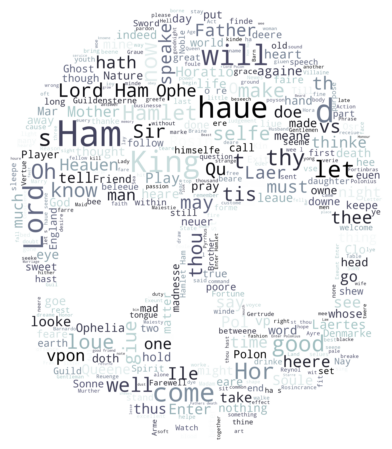

In [104]:
hamlet_corpus = nltk.corpus.gutenberg.words('shakespeare-hamlet.txt')
hamlet_word_list = [''.join(word) for word in hamlet_corpus]
hamlet_as_string = ' '.join(hamlet_word_list)
skull_icon = Image.open('./SpamData/01_Processing/wordcloud_resources/skull-icon.png')
skull_image_mask = Image.new(mode='RGB', size=skull_icon.size, color=(255,255,255))
skull_image_mask.paste(skull_icon, box=skull_icon)

skull_rgb_array = np.array(skull_image_mask)

skull_word_cloud = WordCloud(mask=skull_rgb_array, background_color='white', max_words=400,
                             colormap='bone')
skull_word_cloud.generate(hamlet_as_string)

plt.figure(figsize=[16, 8])
plt.imshow(skull_word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Word Cloud of Ham and Spam Messages

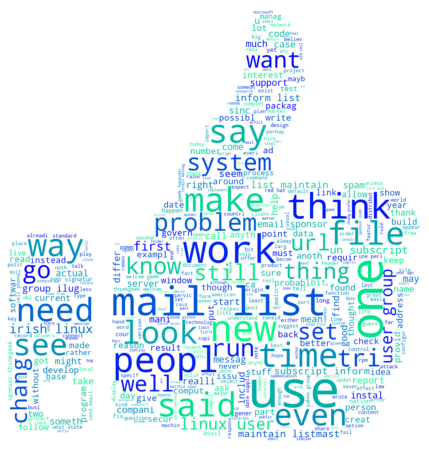

In [107]:
icon = Image.open('SpamData/01_Processing/wordcloud_resources/thumbs-up.png')
image_mask = Image.new(mode='RGB', size=icon.size, color=(255, 255, 255))
image_mask.paste(icon, box=icon)

rgb_array = np.array(image_mask)

ham_str = ' '.join(flat_list_ham)
word_cloud = WordCloud(mask=rgb_array, background_color='white',
                       max_words=400, colormap='winter')
word_cloud.generate(ham_str)

plt.figure(figsize=[16, 8])
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

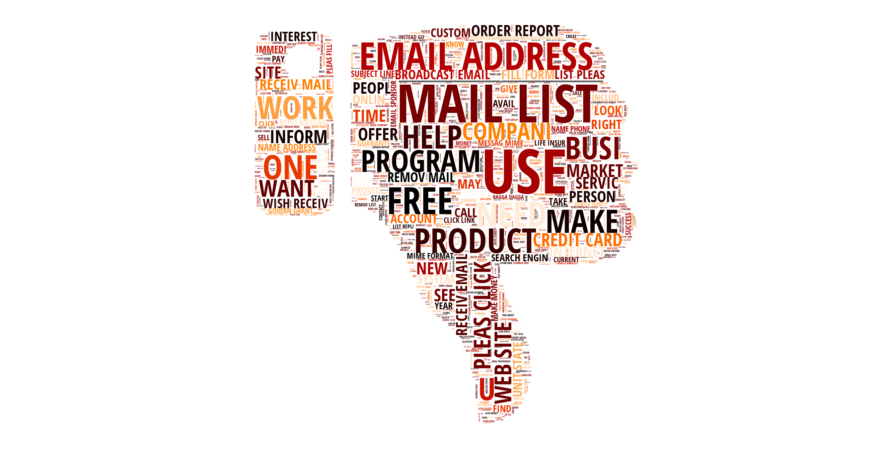

In [109]:
icon = Image.open('SpamData/01_Processing/wordcloud_resources/thumbs-down.png')
image_mask = Image.new(mode='RGB', size=icon.size, color=(255, 255, 255))
image_mask.paste(icon, box=icon)

rgb_array = np.array(image_mask)

spam_str = ' '.join(flat_list_spam).upper()
word_cloud = WordCloud(mask=rgb_array, background_color='white',
                       max_words=400, colormap='gist_heat',
                       font_path='./SpamData/01_Processing/wordcloud_resources/OpenSansCondensed-Bold.ttf')
word_cloud.generate(spam_str)

plt.figure(figsize=[16, 8])
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Generate Vocabulary & Dictionary

In [112]:
stemmed_nested_list = data.MESSAGE.apply(clean_message_no_html)
flat_stemmed_list = [item for sublist in stemmed_nested_list for item in sublist]

/Users/wburn/notebooks/machine-learning-course/venv/lib/python3.9/site-packages/bs4/__init__.py:417: MarkupResemblesLocatorWarning: "http://www.post-gazette.com/columnists/20020905brian5
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(


In [113]:
unique_words = pd.Series(flat_stemmed_list).value_counts()
print('Number of unique words:', unique_words.shape[0])
unique_words.head()

Number of unique words: 27334


http     10660
use       5019
list      4851
email     4367
get       4200
dtype: int64

In [118]:
frequent_words = unique_words[:VOCAB_SIZE]
print("Most common words: \n", frequent_words[:10])

Most common words: 
 http     10660
use       5019
list      4851
email     4367
get       4200
mail      3983
one       3907
free      3202
time      3042
work      2883
dtype: int64


# Create a Vocabulary DataFrame with a WORD_ID

In [120]:
word_ids = list(range(0, VOCAB_SIZE))
vocab = pd.DataFrame({'VOCAB_WORD': frequent_words.index.values}, index=word_ids)
vocab.index.name = "WORD_ID"
vocab.head()

,VOCAB_WORD
WORD_ID,
0,http
1,use
2,list
3,email
4,get


## Save the Vocabulary as a CSV File

In [140]:
vocab.to_csv(WORD_ID_FILE, index_label=vocab.index.name, header=vocab.VOCAB_WORD.name)

# Exercise: Checking if a Word is Part of a Vocabulary

In [138]:
if "app" in set(vocab.VOCAB_WORD.values): print('True')

True


# Exercise: Find the email with the Most Number of Words

In [145]:
clean_email_lengths = []
clean_email_lengths = [len(sublist) for sublist in stemmed_nested_list]
print("Number of words in the longest email:", max(clean_email_lengths))

Number of words in the longest email: 7671


In [146]:
print("Email position in the list (and the dataframe)", np.argmax(clean_email_lengths))

Email position in the list (and the dataframe) 5401


In [147]:
data.at[np.argmax(clean_email_lengths), 'MESSAGE']

'------------------------ Yahoo! Groups Sponsor ---------------------~-->\n\n4 DVDs Free +s&p Join Now\n\nhttp://us.click.yahoo.com/pt6YBB/NXiEAA/Ey.GAA/26EolB/TM\n\n---------------------------------------------------------------------~->\n\n\n\nA new version of unison is now available for testing.  It incorporates\n\nseveral small improvements over 2.9.1, but the main change is a fix to\n\na bug that had potentially serious safety consequences, but only for\n\nthe very small number of users that are in the habit of running more\n\nthan one instance of Unison at a time, in parallel.  These users are\n\nstrongly encouraged to upgrade.  Others can wait if they wish.\n\n\n\nThe release includes pre-built executables for Linux and Solaris, but\n\nnot Windows.  (We are looking for a Unison-Windows maintainer -- at\n\nthe moment, none of the active developers are regularly using Unison\n\non Windows, and we do not have a machine that is configured properly\n\nfor building executables for exp

# Generating Features & a Sparse Matrix

### Creating a DataFframe with one Word per Column

In [148]:
type(stemmed_nested_list)

pandas.core.series.Series

In [149]:
word_columns_df = pd.DataFrame.from_records(stemmed_nested_list.to_list())
word_columns_df.head()

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
0,dear,homeown,interest,rate,lowest,point,year,help,find,best,...,None,None,None,None,None,None,None,None,None,None
1,attent,must,comput,user,packag,deal,norton,systemwork,softwar,suit,...,None,None,None,None,None,None,None,None,None,None
2,messag,mime,format,dare,tri,find,better,annuiti,guarante,year,...,None,None,None,None,None,None,None,None,None,None
3,import,inform,new,domain,name,final,avail,gener,public,discount,...,None,None,None,None,None,None,None,None,None,None
4,bottom,line,give,away,cd,free,peopl,like,one,month,...,None,None,None,None,None,None,None,None,None,None


In [150]:
word_columns_df.shape

(5796, 7671)

### Splitting the data into a Training and Testing Dataset

In [154]:
X_train, X_test, y_train, y_test = train_test_split(word_columns_df, data.CATEGORY,
                                                    test_size=0.3, random_state=42)

In [156]:
print('Number of training samples', X_train.shape[0])
print('Fraction of training set', X_train.shape[0] / word_columns_df.shape[0])

Number of training samples 4057
Fraction of training set 0.6999654934437544


In [157]:
X_train.index.name = X_test.index.name = 'DOC_ID'
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
DOC_ID,,,,,,,,,,,,,,,,,,,,,
4844,thu,jul,rodent,unusu,size,wrote,appli,one,three,order,...,None,None,None,None,None,None,None,None,None,None
4727,well,would,vaniti,list,forward,least,littl,pure,data,week,...,None,None,None,None,None,None,None,None,None,None
5022,world,wide,word,issu,saturday,august,sent,saturday,subscrib,least,...,None,None,None,None,None,None,None,None,None,None
3504,believ,spamassassin,maintain,scheme,wherebi,corpu,distribut,ie,sever,peopl,...,None,None,None,None,None,None,None,None,None,None
3921,sorri,think,send,realiz,list,sender,usual,anyawi,ask,harri,...,None,None,None,None,None,None,None,None,None,None


In [158]:
y_train.head()

DOC_ID
4844    0
4727    0
5022    0
3504    0
3921    0
Name: CATEGORY, dtype: int64

## Create a Sparse Matrix for the Training Data

In [159]:
word_index = pd.Index(vocab.VOCAB_WORD)
type(word_index)

pandas.core.indexes.base.Index

In [160]:
word_index.get_loc('thu')

393

In [162]:
def make_sparse_matrix(df, indexed_words, labels):
    """
    Returns sparse matrix as dataframe.

    :param df: A dataframe with words in the columns with a document id as an index (X_train or X_test)
    :param indexed_words: index of words ordered by word id
    :param labels: category as a series (y_train or y_test)
    :return:
    """

    nr_rows = df.shape[0]
    nr_cols = df.shape[1]
    word_set = set(indexed_words)
    dict_list = []

    for i in range(nr_rows):
        for j in range(nr_cols):

            word = df.iat[i, j]
            if word in word_set:
                doc_id = df.index[i]
                word_id = indexed_words.get_loc(word)
                category = labels.at[doc_id]

                item = {'LABEL': category, 'DOC_ID': doc_id,
                        'OCCURRENCE': 1, 'WORD_ID': word_id}

                dict_list.append(item)

    return pd.DataFrame(dict_list)

In [163]:
%%time
sparse_train_df = make_sparse_matrix(X_train, word_index, y_train)

CPU times: user 12min 32s, sys: 1.49 s, total: 12min 33s
Wall time: 12min 35s


In [164]:
sparse_train_df[:5]

,LABEL,DOC_ID,OCCURRENCE,WORD_ID
0,0,4844,1,393
1,0,4844,1,492
2,0,4844,1,2352
3,0,4844,1,497
4,0,4844,1,37


In [165]:
sparse_train_df.shape

(444959, 4)

### Combine Occurences with the Pandas groupby() method

In [166]:
train_grouped = sparse_train_df.groupby(['DOC_ID', 'WORD_ID', 'LABEL']).sum()
train_grouped.head()

OCCURRENCE
DOC_ID WORD_ID LABEL            
0      0       1               2
       7       1               1
       16      1               1
       18      1               1
       24      1               1

In [167]:
vocab.at[0, 'VOCAB_WORD']

'http'

In [168]:
train_grouped = train_grouped.reset_index()
train_grouped.head()

,DOC_ID,WORD_ID,LABEL,OCCURRENCE
0,0,0,1,2
1,0,7,1,1
2,0,16,1,1
3,0,18,1,1
4,0,24,1,1


In [169]:
train_grouped.shape

(265558, 4)

### Save Training Data as .txt File

In [171]:
np.savetxt(TRAINING_DATA_FILE, train_grouped, fmt='%d')

In [172]:
train_grouped.columns

Index(['DOC_ID', 'WORD_ID', 'LABEL', 'OCCURRENCE'], dtype='object')

### Creating a Sparse Matrix of Test data

In [174]:
%%time
sparse_test_df = make_sparse_matrix(X_test, word_index, y_test)

CPU times: user 6min 11s, sys: 6.58 s, total: 6min 18s
Wall time: 6min 27s


In [176]:
sparse_test_df.shape

(187650, 4)

In [177]:
test_grouped = sparse_test_df.groupby(['DOC_ID', 'WORD_ID', 'LABEL']).sum()
test_grouped.head()

OCCURRENCE
DOC_ID WORD_ID LABEL            
8      7       1               1
       8       1               1
       12      1               1
       21      1               2
       26      1               1

In [181]:
test_grouped.shape
test_grouped = test_grouped.reset_index()
test_grouped.head()

,DOC_ID,WORD_ID,LABEL,OCCURRENCE
0,8,7,1,1
1,8,8,1,1
2,8,12,1,1
3,8,21,1,2
4,8,26,1,1


In [182]:
np.savetxt(TEST_DATA_FILE, test_grouped, fmt='%d')

# Pre-Processing Subtleties and Checking your Understanding

In [183]:
train_doc_ids = set(train_grouped.DOC_ID)
test_doc_ids = set(test_grouped.DOC_ID)

In [185]:
len(test_doc_ids)

1723

In [186]:
len(X_test)

1739

In [187]:
set(X_test.index.values) - test_doc_ids

{14,
 325,
 416,
 445,
 452,
 479,
 576,
 594,
 681,
 856,
 859,
 1001,
 1042,
 1109,
 1361,
 1407}

In [190]:
data.MESSAGE[445]

'------=_NextPart_000_00C3_65E56B8D.B3612A36\n\nContent-Type: text/plain; charset="iso-8859-1"\n\nContent-Transfer-Encoding: base64\n\n\n\nSGVscCB3YW50ZWQuICBXZSBhcmUgYSAxNCB5ZWFyIG9sZCBmb3J0dW5lIDUw\n\nMCBjb21wYW55LCB0aGF0IGlzDQpncm93aW5nIGF0IGEgdHJlbWVuZG91cyBy\n\nYXRlLiAgV2UgYXJlIGxvb2tpbmcgZm9yIGluZGl2aWR1YWxzIHdobw0Kd2Fu\n\ndCB0byB3b3JrIGZyb20gaG9tZS4NCg0KVGhpcyBpcyBhbiBvcHBvcnR1bml0\n\neSB0byBtYWtlIGFuIGV4Y2VsbGVudCBpbmNvbWUuICBObyBleHBlcmllbmNl\n\nDQppcyByZXF1aXJlZC4gIFdlIHdpbGwgdHJhaW4geW91Lg0KDQpTbyBpZiB5\n\nb3UgYXJlIGxvb2tpbmcgdG8gYmUgZW1wbG95ZWQgZnJvbSBob21lIHdpdGgg\n\nYSBjYXJlZXIgdGhhdCBoYXMNCnZhc3Qgb3Bwb3J0dW5pdGllcywgdGhlbiBn\n\nbzoNCg0KaHR0cDovL3d3dy5iYXNldGVsLmNvbToyNzAwMC93ZWFsdGhub3cN\n\nCg0KV2UgYXJlIGxvb2tpbmcgZm9yIGVuZXJnZXRpYyBhbmQgc2VsZiBtb3Rp\n\ndmF0ZWQgcGVvcGxlLiAgSWYgdGhhdCBpcyB5b3UNCnRoYW4gY2xpY2sgb24g\n\ndGhlIGxpbmsgYW5kIGZpbGwgb3V0IHRoZSBmb3JtLCBhbmQgb25lIG9mIG91\n\ncg0KZW1wbG95ZW1lbnQgc3BlY2lhbGlzdCB3aWxsIGNvbnRhY3QgeW91Lg0K\n\nDQpUbyBiZSByZW1vdmVkIGZyb20gb